# 3. Using Pytorch with CapyMOA
* This notebook demonstrates how use Pytorch with CapyMOA.
* It contains examples showing 
    * How to define a Pytorch Network to be used with CapyMOA
    * How a simple Pytorch model can be used in a CapyMOA ```Instance``` loop
    * How to define a Pytorch CapyMOA Classifier based on CapyMOA ```Classifier``` framework and how to use it with ```prequential_evaluation()```
    * How to use a Pytorch dataset with a CapyMOA classifier
* **Tutorial 6**: `Exploring Advanced Features` includes an example using TensorBoard and a `PyTorchClassifier`
 
---

*More information about CapyMOA can be found in* https://www.capymoa.org

**last update on 03/05/2024**

## 1. Setup
* Sets random seed for reproducibility
* Sets Pytorch network 

### 1.1 Set random seeds

In [1]:
import random
random_seed=1
random.seed(random_seed)

### 1.2 Define network structure
* Here, network uses the CPU device

In [2]:
import torch
from torch import nn

torch.manual_seed(random_seed)
torch.use_deterministic_algorithms(True)

# Get cpu device for training.
device = ("cpu")
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=0, number_of_classes=0):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, number_of_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


Using cpu device


### 1.3 Using instance loop
* Model is initialized after receiving the first instance

In [3]:
from capymoa.evaluation import ClassificationEvaluator
from capymoa.datasets import ElectricityTiny

elec_stream = ElectricityTiny()

# Creating the evaluator
evaluator = ClassificationEvaluator(schema=elec_stream.get_schema())

model = None
optimizer = None
loss_fn = nn.CrossEntropyLoss()

i = 0
while elec_stream.has_more_instances():
    i += 1
    instance = elec_stream.next_instance()
    if model is None:
        moa_instance = instance.java_instance.getData()
        # initialize the model and send it to the device
        model = NeuralNetwork(input_size=elec_stream.get_schema().get_num_attributes(), 
                              number_of_classes=elec_stream.get_schema().get_num_classes()).to(device)
        # set the optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
        print(model)
    
    X = torch.tensor(instance.x, dtype=torch.float32)
    y = torch.tensor(instance.y_index, dtype=torch.long)
    # set the device and add a dimension to the tensor
    X, y = torch.unsqueeze(X.to(device), 0), torch.unsqueeze(y.to(device),0) 
    
    # turn off gradient collection for test
    with torch.no_grad():
        pred = model(X)
        prediction = torch.argmax(pred)

    # update evaluator with predicted class
    evaluator.update(instance.y_index, prediction.item())
  
    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 500 == 0:
        print(f'Accuracy at {i} : {evaluator.accuracy()}')
    
print(f'Accuracy at {i} : {evaluator.accuracy()}')

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=6, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)
Accuracy at 500 : 50.4
Accuracy at 1000 : 55.2
Accuracy at 1500 : 61.199999999999996
Accuracy at 2000 : 61.1
Accuracy at 2000 : 61.1


## 2. PyTorchClassifier
* Defining a `PyTorchClassifier` using CapyMOA API makes it **compatibility** with CapyMOA functions like `prequential_evaluation()` without losing the **flexibility** of specifying the `architecture` and the `training` method
* Model is initialized after receiving the first instance
* `PyTorchClassifier` is based on `capymoa.base` ```Classifier``` abstract class

* **Important**: We can access information about the stream through any of its instances. See `set_model(self, instance)` for an example: 

```python
...
moa_instance = instance.java_instance.getData()
self.model = NeuralNetwork(input_size=moa_instance.get_num_attributes(), 
                                       number_of_classes=moa_instance.get_num_classes()).to(self.device)
...
```

In [4]:
from capymoa.base import Classifier
import numpy as np

class PyTorchClassifier(Classifier):
    def __init__(self, schema=None, random_seed=1, nn_model: nn.Module = None, optimizer=None, loss_fn=nn.CrossEntropyLoss(), device=("cpu"), lr=1e-3):
        super().__init__(schema, random_seed)
        self.model = None
        self.optimizer = None
        self.loss_fn = loss_fn
        self.lr = lr
        self.device = device
        
        torch.manual_seed(random_seed)
        
        if nn_model is None:
            self.set_model(None)
        else:
            self.model = nn_model.to(device)
        if optimizer is None:
            if self.model is not None:
                self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)
        else:
            self.optimizer = optimizer
        
    def __str__(self):
        return str(self.model)

    def CLI_help(self):
        return str('schema=None, random_seed=1, nn_model: nn.Module = None, optimizer=None, loss_fn=nn.CrossEntropyLoss(), device=("cpu"), lr=1e-3')

    def set_model(self, instance):
        if self.schema is None:
            moa_instance = instance.java_instance.getData()
            self.model = NeuralNetwork(input_size=moa_instance.get_num_attributes(), 
                                       number_of_classes=moa_instance.get_num_classes()).to(self.device)
        elif instance is not None:
            self.model = NeuralNetwork(input_size=self.schema.get_num_attributes(), 
                                       number_of_classes=self.schema.get_num_classes()).to(self.device)
            
    def train(self, instance):
        if self.model is None:
            self.set_model(instance)
    
        X = torch.tensor(instance.x, dtype=torch.float32)
        y = torch.tensor(instance.y_index, dtype=torch.long)
        # set the device and add a dimension to the tensor
        X, y = torch.unsqueeze(X.to(self.device), 0), torch.unsqueeze(y.to(self.device),0)

        # Compute prediction error
        pred = self.model(X)
        loss = self.loss_fn(pred, y)
    
        # Backpropagation
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

    def predict(self, instance):
        return np.argmax(self.predict_proba(instance))

    def predict_proba(self, instance):
        if self.model is None:
            self.set_model(instance)
        X = torch.unsqueeze(torch.tensor(instance.x, dtype=torch.float32).to(self.device), 0)
        # turn off gradient collection
        with torch.no_grad():
            pred = np.asarray(self.model(X).numpy(), dtype=np.double)
        return pred


### 2.2 Using PyTorchClassifier + prequential_evaluation

* We can access information about the stream through the `schema` directly, from the example below: 
```python
...
nn_model=NeuralNetwork(input_size=elec_stream.get_schema().get_num_attributes(),
                       number_of_classes=elec_stream.get_schema().get_num_classes()).to(device)
...
```

In [5]:
from capymoa.evaluation import prequential_evaluation

## Opening a file as a stream
elec_stream = ElectricityTiny()

# Creating a learner
simple_pyTorch_classifier = PyTorchClassifier(
    schema=elec_stream.get_schema(), 
    nn_model=NeuralNetwork(input_size=elec_stream.get_schema().get_num_attributes(), 
                           number_of_classes=elec_stream.get_schema().get_num_classes()).to(device)
)

evaluator = prequential_evaluation(stream=elec_stream, learner=simple_pyTorch_classifier, window_size=4500, optimise=False)

evaluator['cumulative'].accuracy()

62.849999999999994

## 3. How to use a Pytorch dataset with a CapyMOA classifier
* One may want to use various Pytorch datasets with different CapyMOA classifiers
* In this example we use Pytorch Dataset + prequential evaluation + CapyMOA Classifier

**Observation**: *Using a learner like Online Bagging without any feature extraction is not going to yield meaningful performance*

43.3


,classified instances,classifications correct (percent),Kappa Statistic (percent),Kappa Temporal Statistic (percent),Kappa M Statistic (percent),F1 Score (percent),F1 Score for class 0 (percent),F1 Score for class 1 (percent),F1 Score for class 2 (percent),F1 Score for class 3 (percent),...,Recall for class 0 (percent),Recall for class 1 (percent),Recall for class 2 (percent),Recall for class 3 (percent),Recall for class 4 (percent),Recall for class 5 (percent),Recall for class 6 (percent),Recall for class 7 (percent),Recall for class 8 (percent),Recall for class 9 (percent)
0,100.0,16.0,5.127626,-1.204819,-1.204819,NaN,22.222222,30.769231,46.153846,NaN,...,66.666667,18.181818,33.333333,0.000000,0.000000,0.000000,0.000000,12.500000,0.000000,18.181818
1,200.0,41.0,33.288105,32.954545,30.588235,45.879666,39.130435,57.142857,36.363636,NaN,...,75.000000,40.000000,22.222222,0.000000,22.222222,22.222222,63.636364,23.076923,75.000000,12.500000
2,300.0,29.0,20.996996,21.978022,21.978022,NaN,24.390244,72.727273,51.851852,NaN,...,62.500000,57.142857,53.846154,0.000000,9.090909,18.181818,33.333333,11.111111,18.181818,50.000000
3,400.0,48.0,41.775837,43.478261,42.222222,54.216958,36.363636,70.588235,22.222222,15.384615,...,72.727273,54.545455,25.000000,8.333333,25.000000,66.666667,50.000000,63.636364,66.666667,33.333333
4,500.0,51.0,45.591828,45.555556,42.352941,56.932958,39.024390,50.000000,23.529412,22.222222,...,88.888889,40.000000,16.666667,12.500000,50.000000,75.000000,25.000000,62.500000,78.571429,54.545455
5,600.0,48.0,42.164387,39.534884,36.585366,NaN,38.888889,50.000000,47.058824,NaN,...,70.000000,33.333333,40.000000,0.000000,50.000000,71.428571,46.153846,50.000000,62.500000,61.538462
6,700.0,46.0,39.366719,36.470588,29.870130,NaN,42.105263,80.000000,50.000000,NaN,...,88.888889,66.666667,57.142857,0.000000,61.538462,25.000000,33.333333,22.222222,68.750000,42.857143
7,800.0,55.0,49.301487,49.438202,47.058824,NaN,58.823529,96.551724,60.000000,NaN,...,90.909091,93.333333,50.000000,0.000000,66.666667,53.846154,27.272727,20.000000,63.636364,37.500000
8,900.0,50.0,43.813912,45.652174,42.528736,48.261276,66.666667,81.818182,15.384615,62.500000,...,87.500000,69.230769,16.666667,45.454545,16.666667,50.000000,33.333333,30.000000,44.444444,50.000000
9,1000.0,49.0,43.118447,46.875000,42.045455,54.455830,59.259259,85.714286,55.555556,22.222222,...,88.888889,85.714286,50.000000,12.500000,75.000000,66.666667,27.272727,12.500000,87.500000,12.500000


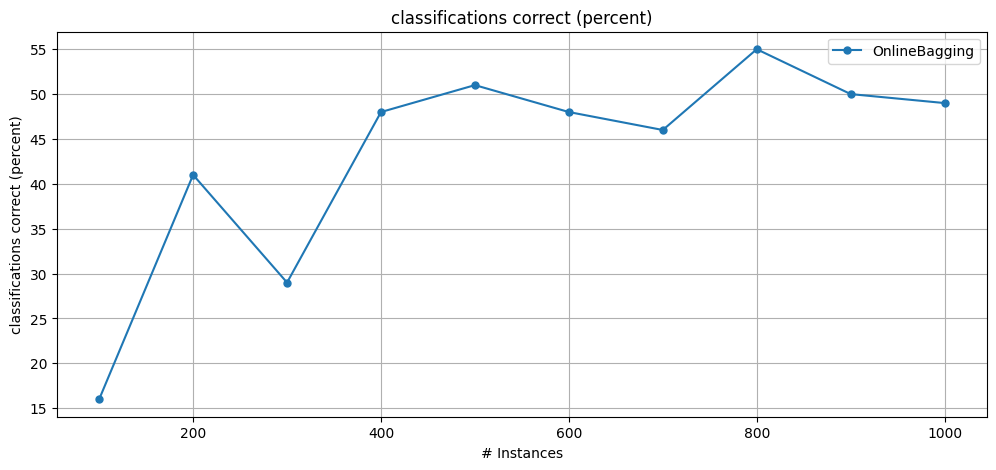

In [6]:
from capymoa.classifier import OnlineBagging
from capymoa.stream import PytorchStream
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results

from torchvision import datasets
from torchvision.transforms import ToTensor

pytorchDtaset = datasets.FashionMNIST(
            root="data",
            train=True,
            download=True,
            transform=ToTensor()
        )
pytorch_stream = PytorchStream(dataset=pytorchDtaset)

# Creating a learner
ob_learner = OnlineBagging(schema=pytorch_stream.get_schema(), ensemble_size=5)

results_ob_learner = prequential_evaluation(stream=pytorch_stream, learner=ob_learner, window_size=100, max_instances=1000)

print(results_ob_learner['cumulative'].accuracy())
display(results_ob_learner['windowed'].metrics_per_window())
plot_windowed_results(results_ob_learner)